# Install & Imports, Set Working Directory
In order to ensure all dependencies are present and file paths resolve correctly, we install needed packages, import modules, and chdir into the notebook’s folder.

In [ ]:
# Install missing packages if required
!python -m pip install umap-learn scikit-learn pandas matplotlib

import os
from sklearn.mixture import GaussianMixture
import numpy as np

from aimon import ChangeEventCollection, ProjectChange

# Determine and switch into the script/notebook directory
try:
    current_dir = os.path.dirname(os.path.abspath(__file__))
except NameError:
    current_dir = os.getcwd()
os.chdir(current_dir)

# Define File Paths & Parameters
To keep everything configurable, we declare input/output paths plus UMAP and GMM hyperparameters in one place.

In [2]:
# Input/output paths
change_events_file       = "../test_data/change_events_labelled.json"
outfolder                = "../test_data/out"
os.makedirs(outfolder, exist_ok=True)

change_events_file_labelled = os.path.join(outfolder, "change_events_labelled_using_umap_and_gmm.json")
umap_model_file             = os.path.join(outfolder, "umap_model.joblib")

# UMAP parameters
random_state      = 3
n_neighbors       = 100
min_dist          = 0.1
n_components_umap = 2
metric            = "manhattan"

# GMM parameters
n_components_GMM = 6


# Load & Preprocess Labelled Events, Fit UMAP
In order to embed events into a low‑dimensional space, we load only those already labelled, filter out unwanted features, then fit and save a UMAP model.

In [3]:
# Load and filter events (e.g. remove any with event_type == "undefined")
ces = ChangeEventCollection.load_from_file(change_events_file)
# Pattern for rule‑based filtering: {"feature_name": {"not_in": value_or_list}} 
# e.g. {"event_type": {"not_in": "undefined"}}
ces.events = ces.filter_events_rule_based({"event_type": {"not_in": "undefined"}})

# Prepare feature matrix, ignoring identifiers and non‑numeric columns
ces.prep_data_for_umap(
    ignore_features=[
        "object_id", "event_type", "delta_t_hours",
        "hull_surface_area", "hull_volume", "number_of_points"
    ],
    supervised_label="event_type"
)

# Fit UMAP and transform
ces.fit_UMAP(
    n_neighbors=n_neighbors,
    min_dist=min_dist,
    n_components=n_components_umap,
    metric=metric,
    random_state=random_state
)
ces.transform_UMAP()

# Save fitted UMAP reducer for reuse
ces.save_UMAP_model(umap_model_file)


UMAP model saved to ../test_data/out\umap_model.joblib


# Visualize Labelled UMAP Embedding
To inspect how known classes separate, we plot the UMAP scatter and a feature‑expression heatmap.

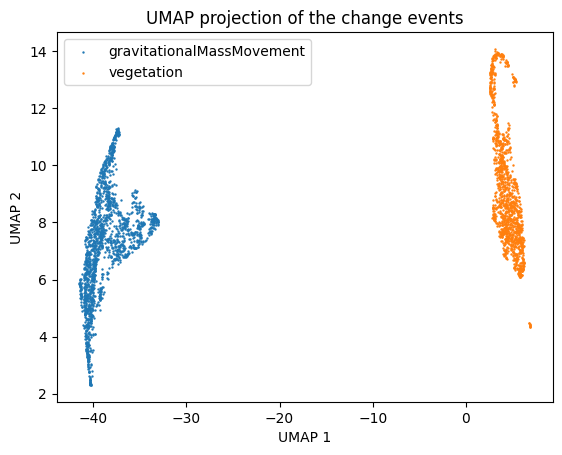

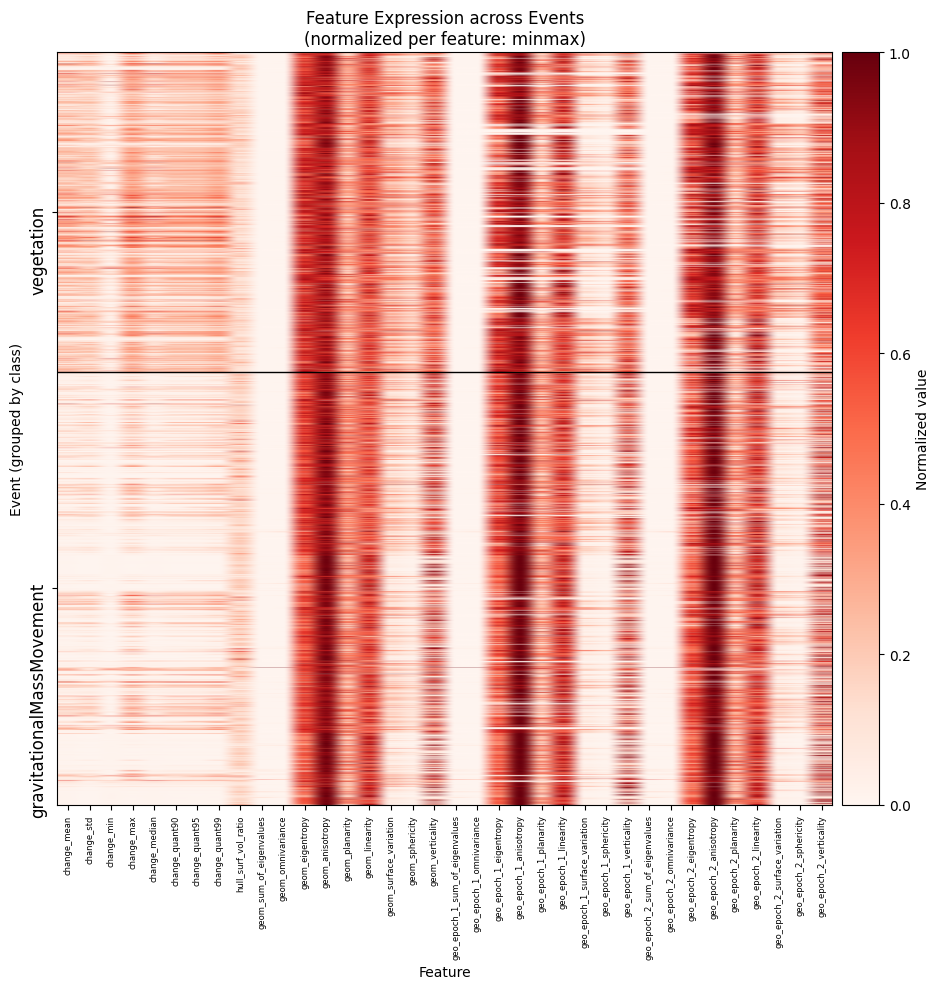

In [4]:
# Scatter of the labelled embedding
ces.plot_UMAP()

# Heatmap showing average feature expression per label
ces.plot_feature_expression_heatmap(cmap="Reds")

# Apply UMAP to All Events (Including “Undefined”)
We reload the full dataset, prep it the same way, load our saved reducer, then embed and visualize everything—this time including those originally “undefined.”

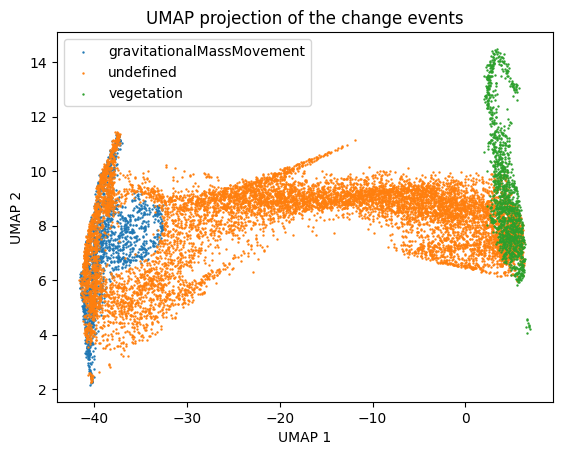

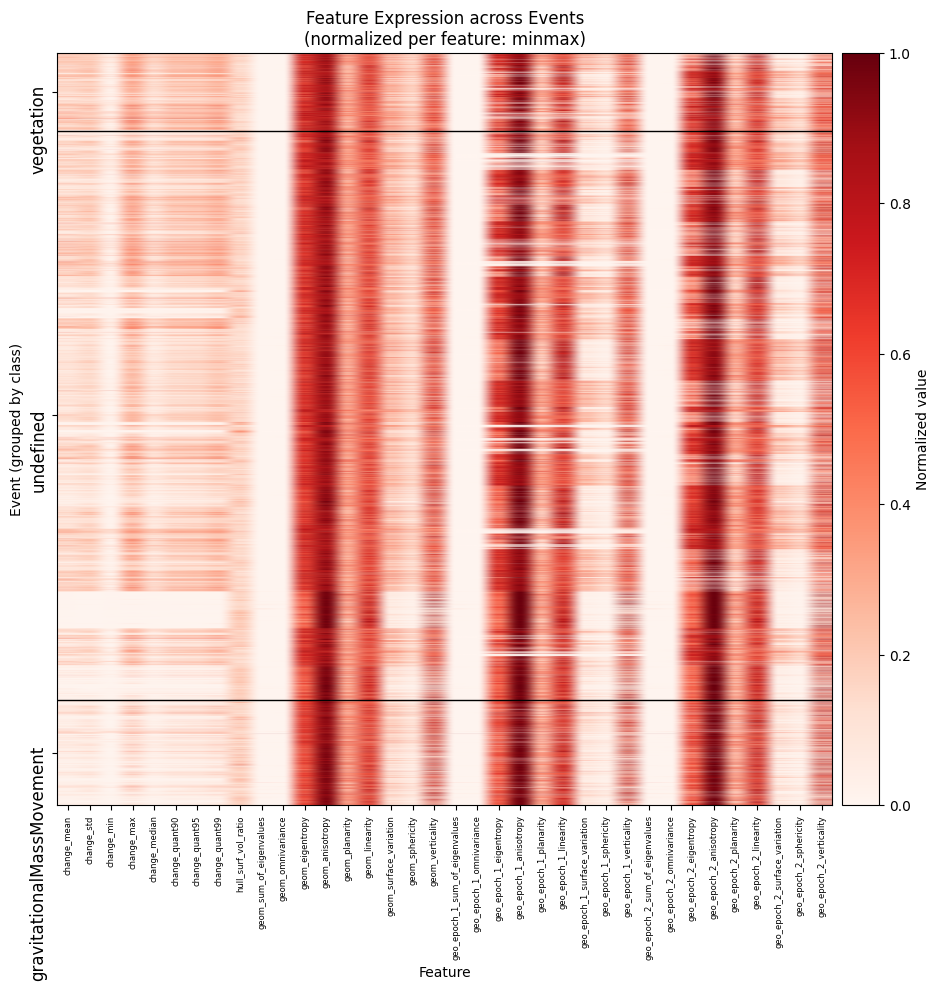

In [5]:
# Reload all events (including undefined)
ces_undef = ChangeEventCollection.load_from_file(change_events_file)

# Prepare for UMAP (same ignored features, but no filtering here)
ces_undef.prep_data_for_umap(
    ignore_features=[
        "object_id", "event_type", "delta_t_hours",
        "hull_surface_area", "hull_volume", "number_of_points"
    ],
    supervised_label="event_type"
)

# Reuse the fitted UMAP model and transform
ces_undef.umap_reducer = ces.umap_reducer
ces_undef.transform_UMAP()

# Visualize full embedding
ces_undef.plot_UMAP()
ces_undef.plot_feature_expression_heatmap()


# Cluster with Gaussian Mixture & Plot
In order to discover groupings among the previously undefined events, we fit a GMM on the UMAP embedding, assign cluster labels, and plot.

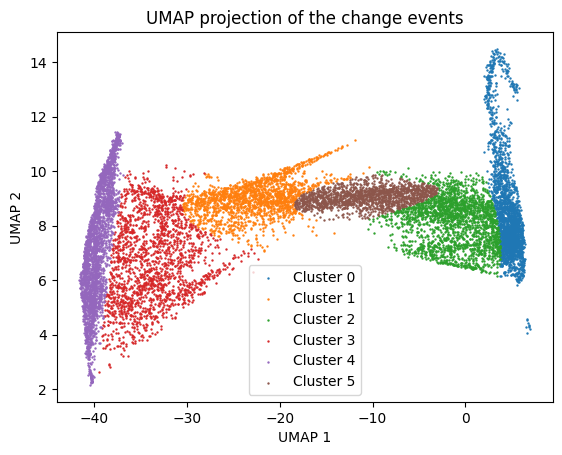

In [6]:
# Fit GMM on the UMAP coordinates
gmm = GaussianMixture(n_components=n_components_GMM, random_state=random_state)
ces_undef.y_umap = gmm.fit_predict(ces_undef.X_umap_transformed)

# Map numeric clusters to human‑readable names
ces_undef.y_label_map = {i: f"Cluster {i}" for i in np.unique(ces_undef.y_umap)}

# Plot the clustered UMAP embedding
ces_undef.plot_UMAP()

# Project Changes into GIS Format
Finally, we wrap up by projecting our labelled events into GeoJSON using ProjectChange.

In [7]:
change_prj = ProjectChange(
    change_event_file     = change_events_file_labelled,
    project_name          = os.path.basename(change_events_file_labelled)[:-5],
    projected_image_folder= "",
    projected_events_folder= outfolder,
    epsg                  = 31254
)

change_prj.project_change()

Missing some information, cannot find 
Missing some information, cannot project change into image
